# 正则化logistic回归

在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。如果你对正则化有点眼生，或者喜欢这一节的方程的背景，请参考在"exercises"文件夹中的"ex2.pdf"。简而言之，正则化是成本函数中的一个术语，它使算法更倾向于“更简单”的模型（在这种情况下，模型将更小的系数）。这个理论助于减少过拟合，提高模型的泛化能力。这样，我们开始吧。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型

## 可视化
小坑：从这里开始到正则化前，请逐块运行代码，才能输出的参考代码的输出结果，具体原因可能是运行到后面变量被覆盖了（真实原因还在查找）

In [1]:
import pandas as pd

path = 'ex2data2.txt'
data = pd.read_csv(path, header=None, names=['test 1', 'test 2','accepted'])
data

,test 1,test 2,accepted
0,0.051267,0.699560,1
1,-0.092742,0.684940,1
2,-0.213710,0.692250,1
3,-0.375000,0.502190,1
4,-0.513250,0.465640,1
...,...,...,...
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0


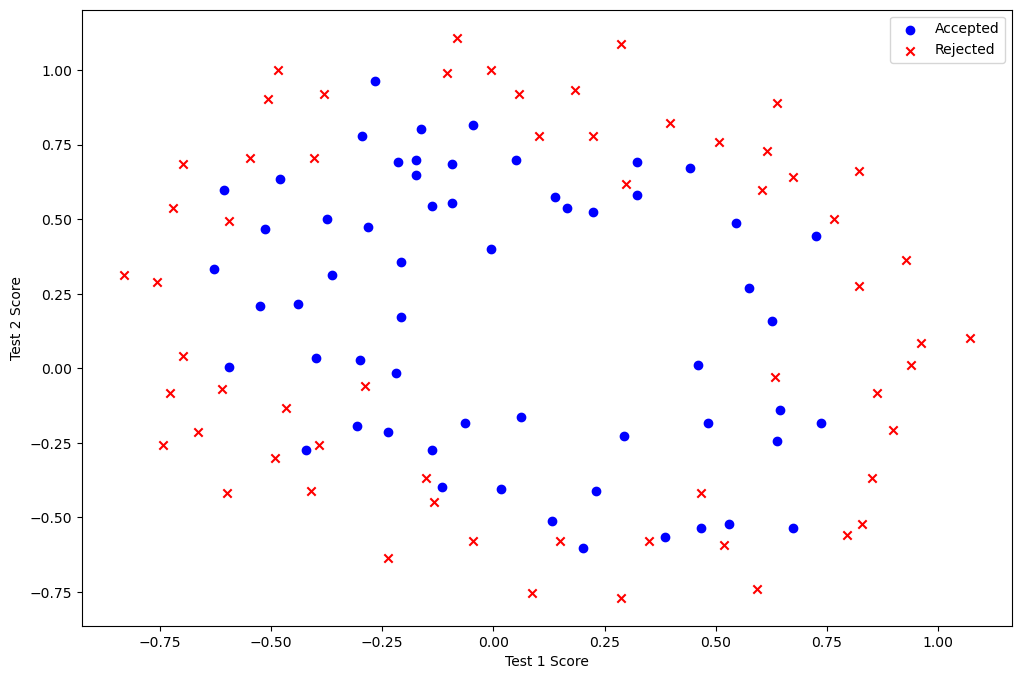

In [2]:
from matplotlib import pyplot as plt

positive = data[data['accepted'].isin([1])]
negative = data[data['accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['test 1'], positive['test 2'], c='b', marker='o', label='Accepted')
ax.scatter(negative['test 1'], negative['test 2'], c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()

In [3]:
degree = 5
x1 = data['test 1']
x2 = data['test 2']

data.insert(3, 'ones', 1)
data

,test 1,test 2,accepted,ones
0,0.051267,0.699560,1,1
1,-0.092742,0.684940,1,1
2,-0.213710,0.692250,1,1
3,-0.375000,0.502190,1,1
4,-0.513250,0.465640,1,1
...,...,...,...,...
113,-0.720620,0.538740,0,1
114,-0.593890,0.494880,0,1
115,-0.484450,0.999270,0,1
116,-0.006336,0.999270,0,1


g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： $g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$
合起来，我们得到逻辑回归模型的假设函数： ${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$

假设原始的特征为 $\( x_1 \)$ 和 $\( x_2 \)$，多项式的阶数为 $\( d \)$（在此为4且从1阶到4阶）。生成的多项式特征包括以下形式：

$$\[
\text{Features} = \{ x_1, x_1^2, x_1 x_2, x_1^3, x_1^2 x_2, x_1 x_2^2, x_2^3, x_1^4, x_1^3 x_2, x_1^2 x_2^2, x_1 x_2^3 \}
\]$$

更一般的表示形式为：

$$\[
\text{Feature}_{ij} = x_1^{(i-j)} \cdot x_2^j \quad \text{where} \quad 0 \leq j \leq i < d
\]$$

完整的特征公式为：

$$\[
\begin{aligned}
&x_1 \\
&x_1^2, \quad x_1 x_2, \\
&x_1^3, \quad x_1^2 x_2, \quad x_1 x_2^2, \\
&x_1^4, \quad x_1^3 x_2, \quad x_1^2 x_2^2, \quad x_1 x_2^3
\end{aligned}
\]$$

In [4]:
import numpy as np

for i in range(1, degree):
    for j in range(0, i):
        data['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data.drop('test 1', axis=1, inplace=True)
data.drop('test 2', axis=1, inplace=True)

data.head()

,accepted,ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [5]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

# *args 的用法在后面会说明
def cost(theta, X, y, lr, *args):
    theta = np.array(theta)
    X = np.array(X)
    y = np.array(y)

    h = logistic(X @ theta)
    return (-np.mean(y * np.log(h) + (1 - y) * np.log(1 - h)) + (np.mean(np.power(theta, 2)) * lr / 2))

In [6]:
cols = data.shape[1]
X = data.iloc[:,1:cols]
y = data.iloc[:,0:1]

X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(11)

lr = 1

cost(theta, X, y, lr)

0.6931471805599453

lr 为 learning rate 用来控制正则化项，这个‘学习率’等下要与下方的梯度下降的‘学习速率’区分开

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$

## 特别说明代码 10~15 行  
因为该函数是使用向量方法进行运算的，而非参考代码遍历得出，所以先对${{\theta }_{0}}$和${{\theta }_{j}}$的公共部分进行计算$a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}}$，（特别注意参考代码没有将${{\alpha}}$写出来，为了与参考代码结果保持一致，将${{\alpha}}$设置为1）然后计算正则化项$\frac{\lambda }{m}{{\theta }_{j}}$，因为${{\theta }_{0}}$是偏置项，不能正则化，所以将${{\theta }_{0}}$的那一行归零。最后，因为是数学公式为加法，在向量计算中也能相加，所以将得到的两个向量相加，得到一个新的向量，该向量可以展开，也可以直接使用。

In [7]:
def gradient(theta, X, y, lr, alpha):
    theta = np.array(theta).reshape(-1, 1)
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    
    m = len(X)

    error = logistic(X @ theta) - y
    
    grad = alpha * (X.T @ error) / m
    
    reg_term = (lr / m) * theta
    reg_term[0] = 0
    
    grad += reg_term
    
    return grad.flatten()

In [8]:
alpha = 1
gradient(theta, X, y, lr, alpha)

array([0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
       0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
       0.00309594])

In [9]:
import scipy.optimize as opt

# 因为 opt.fmin_tnc 方法的原因，cost和gradient的参数数量必须保持一致，所以在cost里面加了一个*args，接受任意参数但不用他们
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y, lr, alpha))
result

(array([ 4.90805342e-04,  2.87956364e-04, -1.49662484e-03, -5.77025928e-04,
         1.17265452e-04, -2.25664701e-04, -4.11306239e-04, -1.13260363e-03,
         2.58958110e-06, -7.98791354e-04, -6.73916190e-05]),
 44,
 1)

In [10]:
def predict(theta, X):
    probability = logistic(X @ theta)
    return [1 if x >= 0.5 else 0 for x in probability]

In [11]:
theta_min = np.array(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) / len(correct))
accuracy

0.652542372881356